In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.layers import Reshape, MaxPool2D, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, GaussianNoise
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model

# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import imageio
import PIL
from IPython import display

# General
import os
import sys
import glob
import time
import random

## Global constants for the model

In [19]:
# DATAPATH = "/Users/Documents/workspacetf/GAN_Project/data/lfwmv"

# file_names = []
# formats = ['.jpg', '.jpeg', '.JPG', '.bmp', '.png']

# for (root, dirs, files) in os.walk(DATAPATH):
#     if len(files) > 0:
#         for file_name in files:
#             file_names.append(file_name)
# #             if os.path.splitext(file_name)[1] in formats:
# #                 tmp = root + '/' + file_name
# #                 path_lists.append(tmp)

# # file_names

# np.save(f'{DATAPATH}/lfw_36_centered', file_names)

In [2]:
SEED = 132957 # 23957
tf.random.set_seed(SEED)
# set_global_determinism(seed=SEED)  # Yet unavailable

PROJECT_ADDRESS = "/Users/Documents/workspacetf/GAN_Project/data/"
DATA_FOLDER = "lfwmv"
DATA_FILENAME = "lfw_36_centered.npy"
# ATTRS_FILENAME = "attrs.csv"

CODE_SIZE = 256
BATCH_SIZE = 256

LEARNING_RATE = 1e-4
# MOMENTUM = 1e-2
EPOCHS = 2000

IMAGE_FOLDER = os.path.join(PROJECT_ADDRESS, "generated_data")
CHECKPOINT_FOLDER = os.path.join(PROJECT_ADDRESS, "training_checkpoints")

In [37]:
# # A deterministic GPU implementation of ResizeNearestNeighborGrad is not currently available.
# """
# def set_global_determinism(seed=SEED):
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     random.seed(seed)
#     tf.random.set_seed(seed)
#     np.random.seed(seed)

#     os.environ['TF_DETERMINISTIC_OPS'] = '1'
#     os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
#     tf.config.threading.set_inter_op_parallelism_threads(1)
#     tf.config.threading.set_intra_op_parallelism_threads(1)
# """;

In [3]:
def show_samples_from_data(data, dims=None, lst=None):
    if dims is None:
        if lst is None:
            dims = (1, 4)
        else:
            dims = (1, len(lst))
    if isinstance(dims, int):
        dims = (1, dims)
    if len(dims) == 1:
        dims = (1, dims[0])
    else:
        dims = tuple(dims)
    
    n = dims[0] * dims[1]
    if lst is None:
        lst = list(np.random.randint(0, data.shape[0], n))
    
    assert len(lst) == n
        
    fig, axs = plt.subplots(dims[0], dims[1], figsize=(4 * dims[1], 4 * dims[0]))
    if dims[0] == 1:
        axs = [axs]
        if dims[1] == 1:
            axs = [axs]

    for i in range(n):
        x, y = i // dims[1], i % dims[1]
        axs[x][y].axes.xaxis.set_ticks([])
        axs[x][y].axes.yaxis.set_ticks([])
        axs[x][y].set(xlabel= f'image #{lst[i]}')
        axs[x][y].imshow(data[lst[i]])

In [4]:
from scipy.stats import gaussian_kde

def plot_distributions(ax, gen_model, disc_model, data, n_samples=1000):
    noise = np.random.normal(size=(n_samples, CODE_SIZE)).astype('float32')
    idxs = np.random.choice(np.arange(data.shape[0]), size=n_samples)

    real_density = gaussian_kde(tf.nn.softmax(discriminator.predict(data[idxs]))[:, 1] + 1e-3)
    real_density.covariance_factor = lambda : .25
    real_density._compute_covariance()
    fake_density = gaussian_kde(
        tf.nn.softmax(discriminator.predict(generator.predict(noise)))[:, 1] + 1e-3)
    fake_density.covariance_factor = lambda : .25
    fake_density._compute_covariance()
    xs = np.linspace(0, 1, 200)

    ax.set_title('Distributions of predictions')
    ax.axes.yaxis.set_ticks([])
    ax.plot(xs, real_density(xs), label='real images')
    ax.plot(xs, fake_density(xs), label='generated images')
    # ax.set_ylim((0,20))
    ax.legend(loc='best')

In [5]:
def show_demo(gen_model, disc_model, shape, code, epoch, 
              show_dist=False, data=None, save=False, save_address=IMAGE_FOLDER):
    generated_images = gen_model(code, training=False)
    probas = tf.nn.softmax(disc_model(generated_images))

    num_subfigs = 1 + show_dist

    fig = plt.figure(figsize=(4*shape[1]*num_subfigs, 4*shape[0]))
    n = shape[0] * shape[1]

    for i in range(n):
        x, y = i // shape[1], i % shape[1]
        ax = plt.subplot2grid((shape[0], shape[1]*num_subfigs), (x, y))

        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
        ax.set(xlabel= f'predicted prob_real: {(probas[i, 1]*100):.2f}%')
        ax.imshow(np.clip(generated_images[i, :, :, :], 0.0, 1.0))

    if show_dist:
        ax = plt.subplot2grid((shape[0], shape[1]*num_subfigs), 
                            (0, shape[1]), colspan=shape[0], rowspan=shape[1])
        plot_distributions(ax, gen_model, disc_model, data)
    plt.tight_layout()

    if save: 
        plt.savefig(os.path.join(save_address, 'image_at_epoch_{:04d}.png'.format(epoch)))
    plt.show()

In [16]:
data = np.load(os.path.join(PROJECT_ADDRESS, DATA_FOLDER, DATA_FILENAME))
# attrs = pd.read_csv(os.path.join(PROJECT_ADDRESS, DATA_FOLDER, ATTRS_FILENAME))

dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(data.shape[0]).batch(BATCH_SIZE)

In [ ]:
tmp_imgpath = os.path.join(PROJECT_ADDRESS, DATA_FOLDER, data[0])

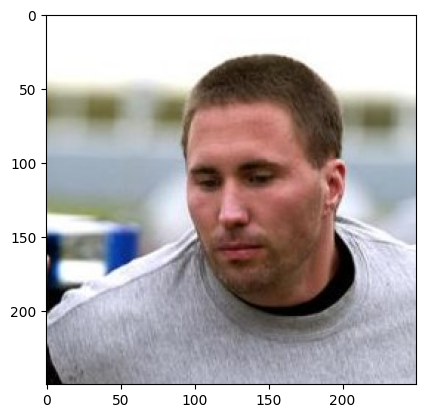

In [25]:
# plt.show(tmp_imgpath)
import matplotlib.image as img

img_test = img.imread(tmp_imgpath)
plt.imshow(img_test)
plt.show()

In [43]:
generator = tf.keras.Sequential([
    Dense(640, input_shape=(CODE_SIZE,), activation='relu'),
    BatchNormalization(),
    Reshape((8, 8, 10)),
    Conv2DTranspose(filters=64, kernel_size=(5, 5), activation='elu'),
    Conv2DTranspose(filters=64, kernel_size=(5, 5), activation='elu'),
    BatchNormalization(),
    UpSampling2D(size=(2, 2)),
    Conv2DTranspose(filters=32, kernel_size=3, activation='elu'),
    Conv2DTranspose(filters=32, kernel_size=3, activation='elu'),
    Conv2DTranspose(filters=32, kernel_size=3, activation='elu'),
    BatchNormalization(),
    Conv2D(filters=3, kernel_size=3, activation=None)
], name="my_generator")

discriminator = tf.keras.Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="elu"),
    MaxPool2D((2, 2)),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3, 3), padding="valid", activation="elu"),
    MaxPool2D((2, 2)),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="elu"),
    MaxPool2D((2, 2)),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="elu"),
    MaxPool2D((2, 2)),
    BatchNormalization(),
    Flatten(),
    Dense(256, activation="elu"),
    Dense(2, activation=tf.nn.log_softmax)
], name="my_discriminator")

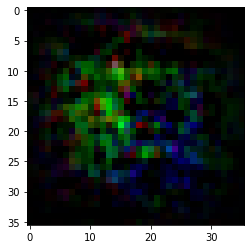

tf.Tensor([[0.47417232 0.5258277 ]], shape=(1, 2), dtype=float32)


In [44]:
# Sanity check.  Thanks Tensorflow 2,
noise = tf.random.normal([1, 256])
generated_image = np.clip(generator(noise, training=False), 0, 1)

plt.imshow(generated_image[0, :, :, :])
plt.show()
print(tf.nn.softmax(discriminator(generated_image, training=False)))

## Loss functions

In [45]:
def discriminator_loss(real_output, fake_output):
    real_loss = BinaryCrossentropy(from_logits=True)(tf.random.uniform(tf.shape(real_output), 
                                                                       0.95, 1.0), real_output)
    fake_loss = BinaryCrossentropy(from_logits=True)(tf.random.uniform(tf.shape(fake_output), 
                                                                       0.0, 0.05), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)

## Optimizers

In [46]:
gen_optimizer = Adam(LEARNING_RATE)
disc_optimizer = Adam(LEARNING_RATE)

## Training

In [47]:
checkpoint_prefix = os.path.join(CHECKPOINT_FOLDER, "ckpt")
checkpoint = tf.train.Checkpoint(gen_optimizer=gen_optimizer,
                                 disc_optimizer=disc_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [48]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, CODE_SIZE])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

In [49]:
samples_shape = (2, 2)
samples_code = tf.random.normal([samples_shape[0]*samples_shape[1], CODE_SIZE])

In [50]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start_time = time.time()
        
        history = []
        for image_batch in dataset:
            train_step(image_batch)

        # Save the model every 100 epochs
        if (epoch + 1) % 100 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        # Demonstrate current progress
        display.clear_output(wait=True)
        show_demo(generator, discriminator, samples_shape, samples_code, epoch + 1, 
                  show_dist=True, data=data, save=True) # (epoch < 30) or (epoch + 1) % 10 == 0

        print ('Epoch #{} completed in {:.2f} sec'.format(epoch + 1, time.time()-start_time))
    
    # Save final image
    display.clear_output(wait=True)
    show_demo(generator, discriminator, samples_shape, samples_code, epoch + 1, 
              show_dist=True, data=data, save=True)

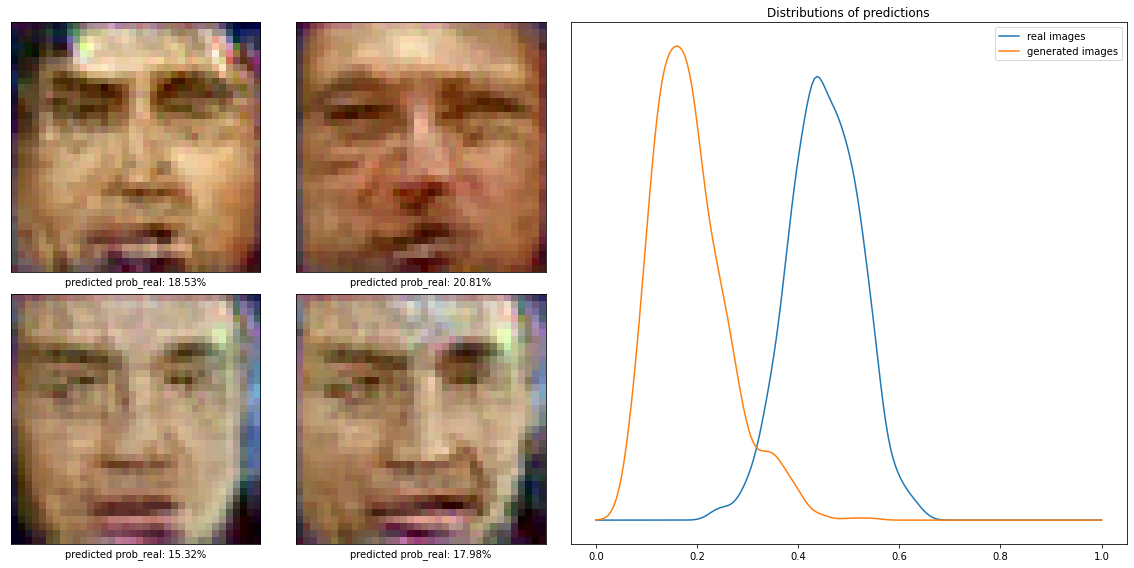

In [55]:
train(dataset, 50)

In [52]:
anim_file = os.path.join(PROJECT_ADDRESS, 'dcgan.gif')

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(IMAGE_FOLDER + '/' + 'image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

## Downloading previous versions

In [ ]:
latest = tf.train.latest_checkpoint(os.path.join(PROJECT_ADDRESS, "training_checkpoints"))
tf.keras.models.load_model(latest)